<a href="https://colab.research.google.com/github/kty3452/ML-Class/blob/main/cnn_ppg_ecg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

tf.random.set_seed(42)
np.random.seed(42)


In [ ]:
# 1) .mat 로딩 함수
def load_signals_from_mat(mat_path, segment_limit=None, verbose=True):
    signals = {'ppg': [], 'ecg': [], 'sbp': [], 'dbp': []}

    with h5py.File(mat_path, 'r') as f:
        sw = f['Subj_Wins']

        ppg_refs = sw['PPG_Raw'][0]
        ecg_refs = sw['ECG_Raw'][0] if 'ECG_Raw' in sw else None
        sbp_refs = sw['SegSBP'][0]
        dbp_refs = sw['SegDBP'][0]

        total = len(ppg_refs)
        if segment_limit is not None:
            total = min(total, segment_limit)

        for i in range(total):
            # PPG
            ppg = f[ppg_refs[i]][()].squeeze().astype(np.float32)
            signals['ppg'].append(ppg)

            # ECG (있으면)
            if ecg_refs is not None:
                ecg = f[ecg_refs[i]][()].squeeze().astype(np.float32)
                signals['ecg'].append(ecg)

            # SBP / DBP
            sbp = float(f[sbp_refs[i]][()].squeeze())
            dbp = float(f[dbp_refs[i]][()].squeeze())
            signals['sbp'].append(sbp)
            signals['dbp'].append(dbp)

    # 리스트 → numpy
    signals['ppg'] = np.stack(signals['ppg'])
    signals['sbp'] = np.array(signals['sbp'], dtype=np.float32)
    signals['dbp'] = np.array(signals['dbp'], dtype=np.float32)

    if len(signals['ecg']) > 0:
        signals['ecg'] = np.stack(signals['ecg'])
    else:
        signals['ecg'] = None

    if verbose:
        sbp = signals['sbp']; dbp = signals['dbp']
        print(f"\n=== {mat_path} ===")
        print(f"총 세그먼트 수: {len(sbp)}")
        print("SBP: mean={:.2f}, min={:.2f}, max={:.2f}, std={:.2f}".format(
            sbp.mean(), sbp.min(), sbp.max(), sbp.std()))
        print("DBP: mean={:.2f}, min={:.2f}, max={:.2f}, std={:.2f}".format(
            dbp.mean(), dbp.min(), dbp.max(), dbp.std()))

    return signals


In [ ]:
# 2) A/B SBP·DBP 트렌드 비교 시각화
def plot_bp_trend(sbp, dbp, subject_id="Subject"):
    x = np.arange(len(sbp))
    plt.figure(figsize=(12,4))
    plt.plot(x, sbp, label="SBP", linewidth=1.2)
    plt.plot(x, dbp, label="DBP", linewidth=1.2)
    plt.xlabel("Segment index")
    plt.ylabel("Blood Pressure (mmHg)")
    plt.title(f"{subject_id} SBP/DBP Trend")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_bp_trend_compare(sigA, sigB, idA="A", idB="B"):
    x = np.arange(len(sigA['sbp']))  # A 기준 인덱스

    plt.figure(figsize=(13,5))
    plt.plot(x, sigA['sbp'], label=f"{idA} SBP")
    plt.plot(x, sigA['dbp'], label=f"{idA} DBP")
    plt.plot(x, sigB['sbp'][:len(x)], label=f"{idB} SBP", linestyle='--')
    plt.plot(x, sigB['dbp'][:len(x)], label=f"{idB} DBP", linestyle='--')

    plt.xlabel("Segment index")
    plt.ylabel("Blood Pressure (mmHg)")
    plt.title(f"SBP/DBP Trend Comparison: {idA} vs {idB}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()



=== /content/drive/MyDrive/PulseDB/p043770.mat ===
총 세그먼트 수: 2000
SBP: mean=130.28, min=107.73, max=148.05, std=6.49
DBP: mean=68.22, min=57.77, max=81.35, std=3.93

=== /content/drive/MyDrive/PulseDB/p045226.mat ===
총 세그먼트 수: 2000
SBP: mean=133.08, min=104.88, max=160.01, std=11.10
DBP: mean=64.92, min=43.22, max=85.81, std=9.65


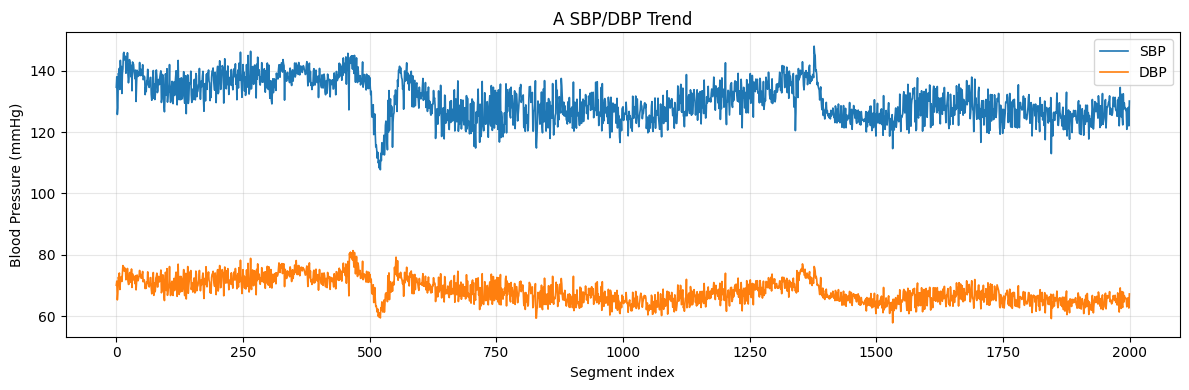

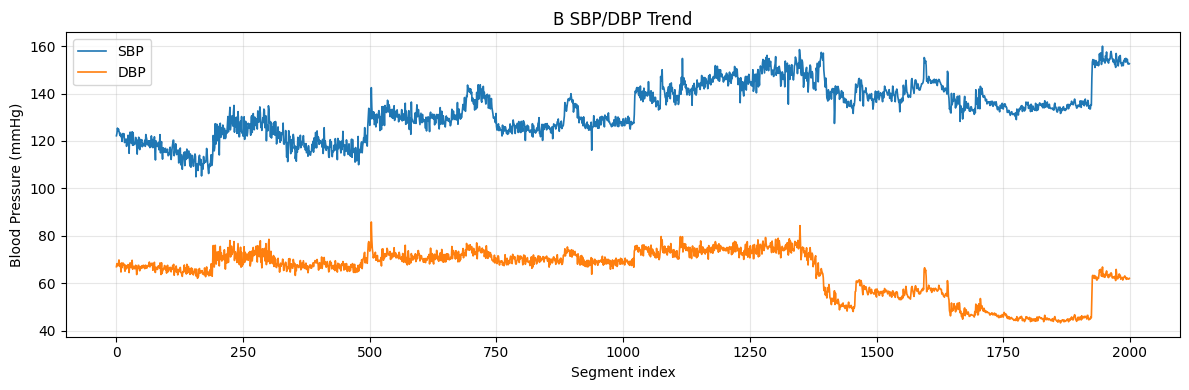

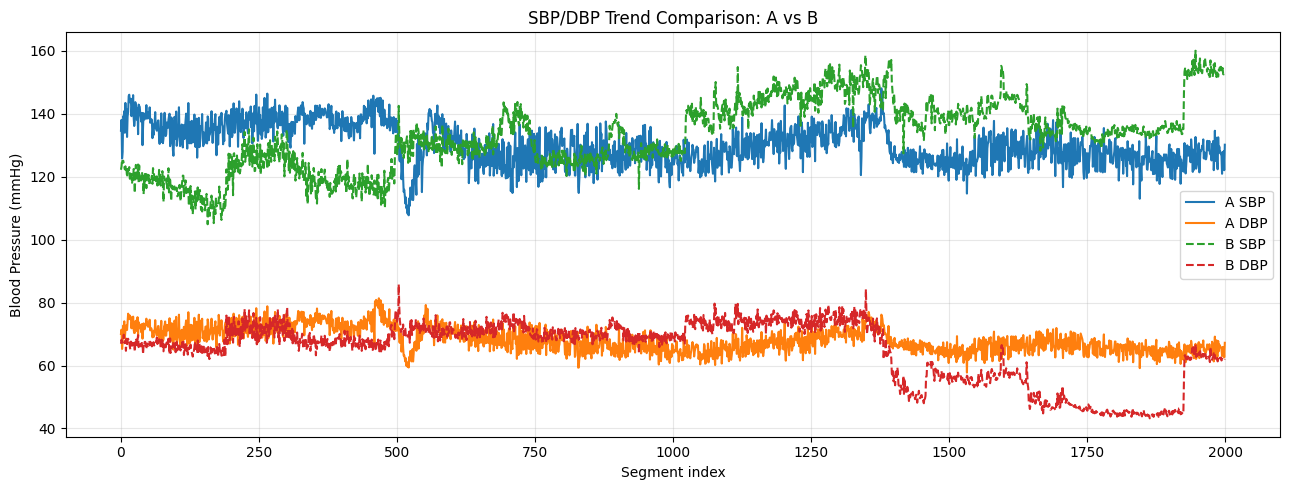

In [ ]:
MAT_A = "/content/drive/MyDrive/PulseDB/p043770.mat"
MAT_B = "/content/drive/MyDrive/PulseDB/p045226.mat"

sigA = load_signals_from_mat(MAT_A, segment_limit=2000, verbose=True)
sigB = load_signals_from_mat(MAT_B, segment_limit=2000, verbose=True)

plot_bp_trend(sigA['sbp'], sigA['dbp'], subject_id="A")
plot_bp_trend(sigB['sbp'], sigB['dbp'], subject_id="B")
plot_bp_trend_compare(sigA, sigB, idA="A", idB="B")


In [ ]:
# 3) 5-fold indices (block 400씩, test는 block 하나)
def make_block_5fold_indices(N, block_size=400):
    """
    N 세그먼트를 block_size(=400)씩 5개로 나누고,
    각 fold마다:
      - test = 한 block (길이 400)
      - train = 나머지 4 block (길이 4*400=1600)
    """
    if N < block_size * 5:
        raise ValueError(f"N={N} < {block_size*5}. 세그먼트가 부족함.")
    blocks = [np.arange(i*block_size, (i+1)*block_size) for i in range(5)]
    indices = []
    for k in range(5):
        test_idx  = blocks[k]
        train_idx = np.concatenate([blocks[j] for j in range(5) if j != k])
        indices.append((train_idx, test_idx))
    return indices


In [ ]:
# 4) z-score 정규화 (train 기준)
def normalize_with_train_stats(x_train, x_other_list):
    """
    x_train 기준 mean/std 계산 후,
    x_other_list 안에 있는 모든 배열에 동일 정규화 적용.
    return: (mean, std, [x_train_norm, ...])
    """
    mean = x_train.mean(axis=(0,1), keepdims=True)
    std  = x_train.std(axis=(0,1), keepdims=True) + 1e-8

    normed = []
    for arr in x_other_list:
        normed.append((arr - mean) / std)
    return mean, std, normed


In [ ]:
# 5) CNN 모델들 (PPG / PPG+ECG)
def build_cnn_ppg(input_len, n_channels):
    inputs = layers.Input(shape=(input_len, n_channels))
    x = layers.Conv1D(32,7,padding='same',activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64,5,padding='same',activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64,activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='linear')(x)  # SBP, DBP
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='mae')
    return model

def build_cnn_ppg_ecg(input_len, n_channels):
    inputs = layers.Input(shape=(input_len, n_channels))
    x = layers.Conv1D(32,7,padding='same',activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64,5,padding='same',activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64,activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='linear')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='mae')
    return model


In [ ]:
def train_on_subject_A(xA, yA, indices, build_model_fn, model_name="Model", verbose_fit=1):
    """
    xA : (N, L, C)  A subject 입력 (PPG-only면 C=1, PPG+ECG면 C=2)
    yA : (N, 2)     [SBP, DBP]
    indices : [(train_idx, test_idx), ...] 5-fold 블록 인덱스
    build_model_fn : 예) build_cnn_ppg, build_cnn_ppg_ecg
    verbose_fit : Keras fit verbose (0 또는 1 추천)

    return:
      - fold_infos : B 평가용 정보 리스트
      - df_A       : A subject에 대한 fold별 성능 테이블
    """
    rows = []
    fold_infos = []

    n_folds = len(indices)
    L = xA.shape[1]
    C = xA.shape[2]

    for fold, (tr_idx, te_idx) in enumerate(indices, 1):
        print("\n" + "=" * 70)
        print(f"[{model_name}] Fold {fold}/{n_folds}  —  Train/Val/Test on A")
        print("=" * 70)

        # 1) train / test split
        x_tr, y_tr = xA[tr_idx], yA[tr_idx]
        x_te, y_te = xA[te_idx], yA[te_idx]

        # 2) validation split (train의 마지막 10%)
        val_size = max(1, int(len(x_tr) * 0.1))
        x_val, y_val = x_tr[-val_size:], y_tr[-val_size:]
        x_tr,  y_tr  = x_tr[:-val_size], y_tr[:-val_size]

        # 3) z-score 정규화 (train 기준)
        mean = x_tr.mean(axis=(0, 1), keepdims=True)
        std  = x_tr.std(axis=(0, 1), keepdims=True) + 1e-6

        x_tr_n  = (x_tr  - mean) / std
        x_val_n = (x_val - mean) / std
        x_te_n  = (x_te  - mean) / std

        # 4) 모델 생성 (시그니처에 따라 자동 대응)
        try:
            model = build_model_fn(L, C)   # build_cnn(L, C) 스타일
        except TypeError:
            model = build_model_fn(L)      # build_cnn(L) 스타일

        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-3),
            loss='mae'
        )

        es   = callbacks.EarlyStopping(
            patience=10, restore_best_weights=True, monitor='val_loss'
        )
        rlrp = callbacks.ReduceLROnPlateau(
            patience=5, factor=0.5, min_lr=1e-5, monitor='val_loss'
        )

        # 5) 학습 (여기서 verbose_fit=1이면 epoch 로그 다 나옴)
        history = model.fit(
            x_tr_n, y_tr,
            validation_data=(x_val_n, y_val),
            epochs=80,
            batch_size=32,
            shuffle=False,
            callbacks=[es, rlrp],
            verbose=verbose_fit
        )

        best_val = np.min(history.history["val_loss"])
        print(f"\n[{model_name}] Fold {fold} — best val_loss: {best_val:.4f}")

        # 6) A subject test 평가
        y_pred = model.predict(x_te_n, verbose=0)
        sbp_mae  = mean_absolute_error(y_te[:, 0], y_pred[:, 0])
        dbp_mae  = mean_absolute_error(y_te[:, 1], y_pred[:, 1])
        sbp_rmse = np.sqrt(mean_squared_error(y_te[:, 0], y_pred[:, 0]))
        dbp_rmse = np.sqrt(mean_squared_error(y_te[:, 1], y_pred[:, 1]))

        print(f"[{model_name}] Fold {fold} (A-test) — "
              f"SBP_MAE={sbp_mae:.2f}, DBP_MAE={dbp_mae:.2f}, "
              f"SBP_RMSE={sbp_rmse:.2f}, DBP_RMSE={dbp_rmse:.2f}")

        rows.append({
            "Fold": fold,
            "SBP_MAE": sbp_mae,
            "DBP_MAE": dbp_mae,
            "SBP_RMSE": sbp_rmse,
            "DBP_RMSE": dbp_rmse,
        })

        # 7) B 평가용 정보 저장 (이게 evaluate_on_subject_B에서 쓰임)
        fold_infos.append({
            "fold": fold,
            "model": model,
            "mean": mean,
            "std": std,
            "te_idx": te_idx,   # 이 구간을 B에서도 그대로 사용
        })

    df_A = pd.DataFrame(rows)

    # 8) A subject 전체 요약
    print("\n" + "#" * 70)
    print(f"[{model_name}] Subject A — 5-Fold Summary (MAE / RMSE)")
    print("#" * 70)
    summary_A = df_A[["SBP_MAE", "DBP_MAE", "SBP_RMSE", "DBP_RMSE"]].agg(["mean", "std"])
    with pd.option_context('display.float_format', lambda v: f"{v:6.3f}"):
        print(summary_A)

    return fold_infos, df_A


In [ ]:
# =========================================================
# B subject 5-fold cross-subject 평가
#  - A에서 학습된 각 fold 모델을, 같은 test 구간 인덱스로 B에 적용
# =========================================================
def evaluate_on_subject_B(xB, yB, fold_infos, model_name="Model"):
    """
    xB, yB : B subject 데이터 (A와 동일한 길이/블록 구조)
    fold_infos : train_on_subject_A 에서 나온 리스트
                 각 원소에 model, mean, std, te_idx 포함
    """
    rows = []

    print("\n" + "=" * 70)
    print(f"[{model_name}] Cross-Subject Evaluation on B")
    print("=" * 70)

    for info in fold_infos:
        fold  = info["fold"]
        model = info["model"]
        mean  = info["mean"]
        std   = info["std"]
        te_idx = info["te_idx"]

        # A에서 쓰던 test 구간 그대로 사용
        xB_te, yB_te = xB[te_idx], yB[te_idx]

        # A-train 기준 정규화(같은 mean/std 사용)
        xB_te_n = (xB_te - mean) / (std + 1e-6)

        # B subject 평가
        y_pred = model.predict(xB_te_n, verbose=0)
        sbp_mae  = mean_absolute_error(yB_te[:, 0], y_pred[:, 0])
        dbp_mae  = mean_absolute_error(yB_te[:, 1], y_pred[:, 1])
        sbp_rmse = np.sqrt(mean_squared_error(yB_te[:, 0], y_pred[:, 0]))
        dbp_rmse = np.sqrt(mean_squared_error(yB_te[:, 1], y_pred[:, 1]))

        print(f"[{model_name}] Fold {fold} (B-cross) — "
              f"SBP_MAE={sbp_mae:.2f}, DBP_MAE={dbp_mae:.2f}, "
              f"SBP_RMSE={sbp_rmse:.2f}, DBP_RMSE={dbp_rmse:.2f}")

        rows.append({
            "Fold": fold,
            "SBP_MAE": sbp_mae,
            "DBP_MAE": dbp_mae,
            "SBP_RMSE": sbp_rmse,
            "DBP_RMSE": dbp_rmse,
        })

    df_B = pd.DataFrame(rows)

    print("\n" + "#" * 70)
    print(f"[{model_name}] Subject B — Cross-Subject 5-Fold Summary")
    print("#" * 70)
    summary_B = df_B[["SBP_MAE", "DBP_MAE", "SBP_RMSE", "DBP_RMSE"]].agg(["mean", "std"])
    with pd.option_context('display.float_format', lambda v: f"{v:6.3f}"):
        print(summary_B)

    return df_B, summary_B


In [ ]:
# =========================================================
#  결과 요약을 예쁘게 출력하는 함수
# =========================================================
def print_pretty_results(df_A, df_B, model_name="CNN-PPG"):
    # 출력 소수점 자리 통일
    df_A_round = df_A.copy().round(3)
    df_B_round = df_B.copy().round(3)

    # A/B 각각 평균 + 표준편차
    cols = ["SBP_MAE", "DBP_MAE", "SBP_RMSE", "DBP_RMSE"]
    A_mean = df_A[cols].mean()
    A_std  = df_A[cols].std()
    B_mean = df_B[cols].mean()
    B_std  = df_B[cols].std()

    summary_A = pd.DataFrame({"mean": A_mean.round(3), "std": A_std.round(3)})
    summary_B = pd.DataFrame({"mean": B_mean.round(3), "std": B_std.round(3)})

    print("\n" + "="*70)
    print(f"▶ {model_name} - A Subject 5-Fold 결과 (within-subject)")
    print("="*70)
    print(df_A_round.to_string(index=False))

    print("\n[ A Subject 요약 (평균 ± 표준편차) ]")
    print(summary_A)

    print("\n" + "="*70)
    print(f"▶ {model_name} - B Subject 5-Fold 결과 (cross-subject)")
    print("="*70)
    print(df_B_round.to_string(index=False))

    print("\n[ B Subject 요약 (평균 ± 표준편차) ]")
    print(summary_B)


In [ ]:
# 공통 준비: N=2000 기준
N = min(len(sigA['ppg']), len(sigB['ppg']), 2000)

ppgA = sigA['ppg'][:N]
ppgB = sigB['ppg'][:N]
sbpA = sigA['sbp'][:N]
dbpA = sigA['dbp'][:N]
sbpB = sigB['sbp'][:N]
dbpB = sigB['dbp'][:N]

xA_ppg = ppgA[..., None]  # (N, L, 1)
xB_ppg = ppgB[..., None]

yA = np.stack([sbpA, dbpA], axis=1)
yB = np.stack([sbpB, dbpB], axis=1)

indices = make_block_5fold_indices(N, block_size=400)

In [ ]:
fold_infos_ppg, df_A_ppg = train_on_subject_A(
    xA_ppg, yA, indices,
    build_model_fn=build_cnn_ppg,
    model_name="CNN-PPG",
    verbose_fit=1
)


[CNN-PPG] Fold 1/5  —  Train/Val/Test on A
Epoch 1/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - loss: 98.3207 - val_loss: 78.0192 - learning_rate: 0.0010
Epoch 2/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 57.4236 - val_loss: 6.1652 - learning_rate: 0.0010
Epoch 3/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 18.6073 - val_loss: 5.1461 - learning_rate: 0.0010
Epoch 4/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 16.4763 - val_loss: 4.5236 - learning_rate: 0.0010
Epoch 5/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 15.1841 - val_loss: 4.3432 - learning_rate: 0.0010
Epoch 6/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 14.4709 - val_loss: 4.8917 - learning_rate: 0.0010
Epoch 7/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 14.3478 - val_loss: 4.4272 - learning_rate: 0.0010
Epoch 8/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 14.1790 - val_loss: 4.3065 - learning_rate: 0.0010
Epoch 9/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 14.3961 - val_l

In [ ]:
df_B_ppg, summary_B_ppg = evaluate_on_subject_B(
    xB_ppg, yB,
    fold_infos_ppg,
    model_name="CNN-PPG"
)


[CNN-PPG] Cross-Subject Evaluation on B
[CNN-PPG] Fold 1 (B-cross) — SBP_MAE=6.04, DBP_MAE=4.87, SBP_RMSE=7.50, DBP_RMSE=6.07
[CNN-PPG] Fold 2 (B-cross) — SBP_MAE=7.38, DBP_MAE=6.07, SBP_RMSE=8.87, DBP_RMSE=6.82
[CNN-PPG] Fold 3 (B-cross) — SBP_MAE=9.18, DBP_MAE=5.96, SBP_RMSE=12.10, DBP_RMSE=6.71
[CNN-PPG] Fold 4 (B-cross) — SBP_MAE=16.21, DBP_MAE=14.60, SBP_RMSE=20.14, DBP_RMSE=17.61
[CNN-PPG] Fold 5 (B-cross) — SBP_MAE=9.43, DBP_MAE=20.72, SBP_RMSE=12.04, DBP_RMSE=22.48

######################################################################
[CNN-PPG] Subject B — Cross-Subject 5-Fold Summary
######################################################################
      SBP_MAE  DBP_MAE  SBP_RMSE  DBP_RMSE
mean    9.646   10.444    12.128    11.941
std     3.920    6.949     4.903     7.604


In [ ]:
print_pretty_results(df_A_ppg, df_B_ppg, model_name="CNN-PPG")


▶ CNN-PPG - A Subject 5-Fold 결과 (within-subject)
 Fold  SBP_MAE  DBP_MAE  SBP_RMSE  DBP_RMSE
    1    4.560    3.025     5.938     3.871
    2    6.770    4.141     8.557     5.183
    3    3.565    2.128     4.521     2.631
    4   10.939    8.165    13.719     9.934
    5    8.940    4.755    10.720     5.711

[ A Subject 요약 (평균 ± 표준편차) ]
           mean    std
SBP_MAE   6.955  3.045
DBP_MAE   4.443  2.314
SBP_RMSE  8.691  3.687
DBP_RMSE  5.466  2.770

▶ CNN-PPG - B Subject 5-Fold 결과 (cross-subject)
 Fold  SBP_MAE  DBP_MAE  SBP_RMSE  DBP_RMSE
    1    6.043    4.870     7.502     6.070
    2    7.377    6.068     8.872     6.823
    3    9.177    5.962    12.096     6.713
    4   16.209   14.603    20.136    17.614
    5    9.426   20.718    12.036    22.482

[ B Subject 요약 (평균 ± 표준편차) ]
            mean    std
SBP_MAE    9.646  3.920
DBP_MAE   10.444  6.949
SBP_RMSE  12.128  4.903
DBP_RMSE  11.941  7.604


In [ ]:
# ECG가 없으면 에러 처리
if sigA['ecg'] is None or sigB['ecg'] is None:
    print("⚠ ECG 신호가 없는 subject입니다. PPG-only만 사용 가능.")
else:
    ecgA = sigA['ecg'][:N]
    ecgB = sigB['ecg'][:N]

    xA_mix = np.stack([ppgA, ecgA], axis=-1)  # (N, L, 2)
    xB_mix = np.stack([ppgB, ecgB], axis=-1)

In [ ]:
fold_infos_mix, df_A_mix = train_on_subject_A(
    xA_mix, yA, indices,
    build_model_fn=build_cnn_ppg_ecg,
    model_name="CNN-PPG+ECG",
    verbose_fit=1
)


[CNN-PPG+ECG] Fold 1/5  —  Train/Val/Test on A
Epoch 1/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 97.1493 - val_loss: 66.5407 - learning_rate: 0.0010
Epoch 2/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 41.6624 - val_loss: 4.0772 - learning_rate: 0.0010
Epoch 3/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 14.0325 - val_loss: 3.1716 - learning_rate: 0.0010
Epoch 4/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 13.6781 - val_loss: 3.0514 - learning_rate: 0.0010
Epoch 5/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 13.7324 - val_loss: 3.1511 - learning_rate: 0.0010
Epoch 6/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 12.9413 - val_loss: 2.9596 - learning_rate: 0.0010
Epoch 7/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 13.0287 - val_loss: 2.7973 - learning_rate: 0.0010
Epoch 8/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 12.4551 - val_loss: 2.7856 - learning_rate: 0.0010
Epoch 9/80
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 12.1658 - v

In [ ]:
df_B_mix, summary_B_mix = evaluate_on_subject_B(
    xB_mix, yB,
    fold_infos_mix,
    model_name="CNN-PPG+ECG"
)


[CNN-PPG+ECG] Cross-Subject Evaluation on B
[CNN-PPG+ECG] Fold 1 (B-cross) — SBP_MAE=54.51, DBP_MAE=21.91, SBP_RMSE=55.36, DBP_RMSE=22.49
[CNN-PPG+ECG] Fold 2 (B-cross) — SBP_MAE=30.05, DBP_MAE=10.66, SBP_RMSE=31.48, DBP_RMSE=11.31
[CNN-PPG+ECG] Fold 3 (B-cross) — SBP_MAE=7.96, DBP_MAE=3.06, SBP_RMSE=9.33, DBP_RMSE=3.68
[CNN-PPG+ECG] Fold 4 (B-cross) — SBP_MAE=9.97, DBP_MAE=16.22, SBP_RMSE=11.87, DBP_RMSE=19.47
[CNN-PPG+ECG] Fold 5 (B-cross) — SBP_MAE=28.30, DBP_MAE=38.43, SBP_RMSE=30.11, DBP_RMSE=39.29

######################################################################
[CNN-PPG+ECG] Subject B — Cross-Subject 5-Fold Summary
######################################################################
      SBP_MAE  DBP_MAE  SBP_RMSE  DBP_RMSE
mean   26.158   18.054    27.631    19.249
std    18.821   13.349    18.530    13.391


In [ ]:
print_pretty_results(df_A_mix, df_B_mix, model_name="CNN-PPG+ECG")


▶ CNN-PPG+ECG - A Subject 5-Fold 결과 (within-subject)
 Fold  SBP_MAE  DBP_MAE  SBP_RMSE  DBP_RMSE
    1    6.165    2.678     7.121     3.304
    2    7.623    3.392     9.837     4.266
    3    4.730    3.151     6.105     3.953
    4    4.058    2.412     5.286     3.039
    5    5.145    2.410     6.362     3.140

[ A Subject 요약 (평균 ± 표준편차) ]
           mean    std
SBP_MAE   5.544  1.391
DBP_MAE   2.809  0.445
SBP_RMSE  6.942  1.746
DBP_RMSE  3.541  0.540

▶ CNN-PPG+ECG - B Subject 5-Fold 결과 (cross-subject)
 Fold  SBP_MAE  DBP_MAE  SBP_RMSE  DBP_RMSE
    1   54.508   21.911    55.365    22.493
    2   30.054   10.657    31.476    11.312
    3    7.958    3.061     9.326     3.685
    4    9.966   16.218    11.875    19.472
    5   28.303   38.426    30.111    39.285

[ B Subject 요약 (평균 ± 표준편차) ]
            mean     std
SBP_MAE   26.158  18.821
DBP_MAE   18.054  13.349
SBP_RMSE  27.631  18.530
DBP_RMSE  19.249  13.391
